/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


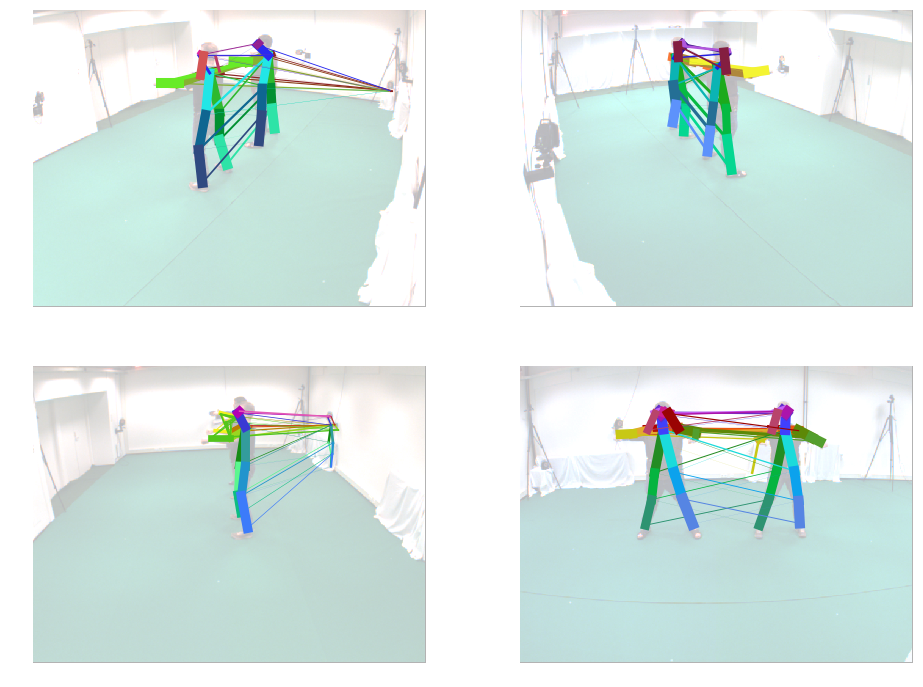

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm
from mvpose.candidates import peaks as mvpeaks
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

FRAME = 0

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False



if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    if isfile('/tmp/heatmaps.npy') and isfile('/tmp/pafs.npy'):
        heatmaps = np.load('/tmp/heatmaps.npy')
        pafs = np.load('/tmp/pafs.npy')
    else:
        hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
        paf_file = '/tmp/pafs' + str(FRAME) + '.npy'

        if isfile(hm_file) and isfile(paf_file):
            heatmaps = np.load(hm_file)
            pafs = np.load(paf_file)
        else:
            heatmaps = []; pafs = []
            for im in Im:
                _start = time()
                hm, paf = pe.predict_pafs_and_heatmaps(im)
                heatmaps.append(np.squeeze(hm))
                pafs.append(np.squeeze(paf))
                _end = time()
                print('elapsed:', _end - _start)
            heatmaps = np.array(heatmaps)
            pafs = np.array(pafs)
            np.save(hm_file, heatmaps)
            np.save(paf_file, pafs)
        
import mvpose.plot.limbs as pltlimbs

fig = plt.figure(figsize=(16,12))

Calib_undist = []
Peaks_undist = []
Peaks = []
Limb_Weights = []
Im_undist = []

for cid, cam in enumerate(Calib):
    hm = heatmaps[cid]
    im = Im[cid]
    paf = pafs[cid]
    peaks = mvhm.get_all_peaks(hm)
    Peaks.append(peaks)
    limbs = mvpafs.calculate_limb_weights(peaks, paf)
    Limb_Weights.append(limbs)
    ax = fig.add_subplot(2,2,cid+1)
    pltlimbs.plot(ax, Im[cid], peaks, limbs); ax.axis('off')
    
    K, rvec, tvec, distCoef = gm.get_camera_parameters(cam)
    im_ud, K_new = gm.remove_distortion(im, cam)
    Im_undist.append(im_ud)
    h,w,_ = hm.shape
    mapx, mapy = \
        cv2.initUndistortRectifyMap(
            K, distCoef, None, K_new, (w, h), 5)
    peaks_undist = mvpeaks.Peaks.undistort(peaks, mapx, mapy)
    Peaks_undist.append(peaks_undist)
    
    assert peaks_undist.n_joints == peaks.n_joints
    for __k in range(peaks_undist.n_joints):
        p1 = peaks[__k]
        p2 = peaks_undist[__k]
        assert p1.shape == p2.shape, 'k:' + str(__k)
    
    Calib_undist.append({
        'K': K_new,
        'distCoeff': 0,
        'rvec': rvec,
        'tvec': tvec
    })
    
plt.show()

2d:
	peaks1: (2, 3)
	peaks2: (2, 3)

3d:
	3d peaks: (4, 4)
elapsed 0.007503032684326172

n3d argmax:
	3d peaks: (2, 4)
	0 -> 0
	1 -> 1


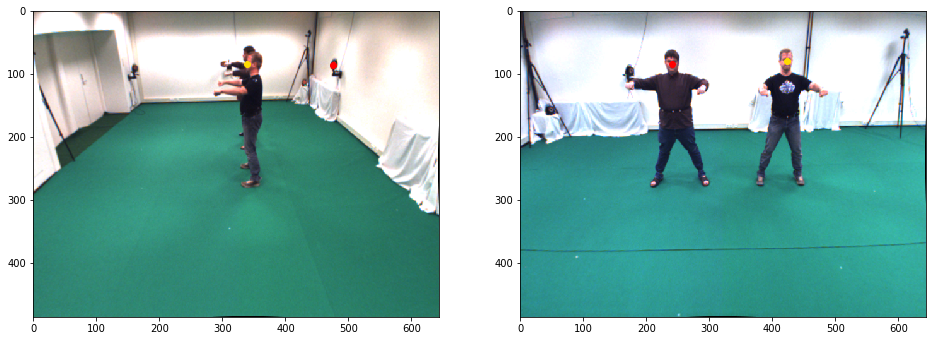

In [2]:
from cselect import color as cs

cam1 = 2; cam2 = 3
J = 0

K1, rvec1, tvec1, _ = gm.get_camera_parameters(Calib_undist[cam1])
peaks1 = Peaks_undist[cam1]
K2, rvec2, tvec2, _ = gm.get_camera_parameters(Calib_undist[cam2])
peaks2 = Peaks_undist[cam2]

print('2d:')
print('\tpeaks1:',peaks1[J].shape)
print('\tpeaks2:',peaks2[J].shape)

joints_3d, idx_pairs = stereo.triangulate(peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)

print('\n3d:')
print('\t3d peaks:', joints_3d[J].shape)


# ------------

_start = time()
pts3d, idx_pairs = stereo.triangulate_argmax(
    peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
_end = time()
print('elapsed', _end - _start)

print('\nn3d argmax:')
print('\t3d peaks:', pts3d[J].shape)
for a,b in idx_pairs[J]:
    print('\t' + str(a) + ' -> ' + str(b))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plot figure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121); ax.imshow(Im_undist[cam1])
ay = fig.add_subplot(122); ay.imshow(Im_undist[cam2])

COLOR1 = cs.lincolor(8)/255
COLOR2 = cs.lincolor(8)/255

for idx, (x,y,score) in enumerate(peaks1[J]):
    ax.scatter(x,y, color=COLOR1[idx])

for idx, (x,y,score) in enumerate(peaks2[J]):
    ay.scatter(x,y, color=COLOR2[idx])

elapsed 0.3524951934814453


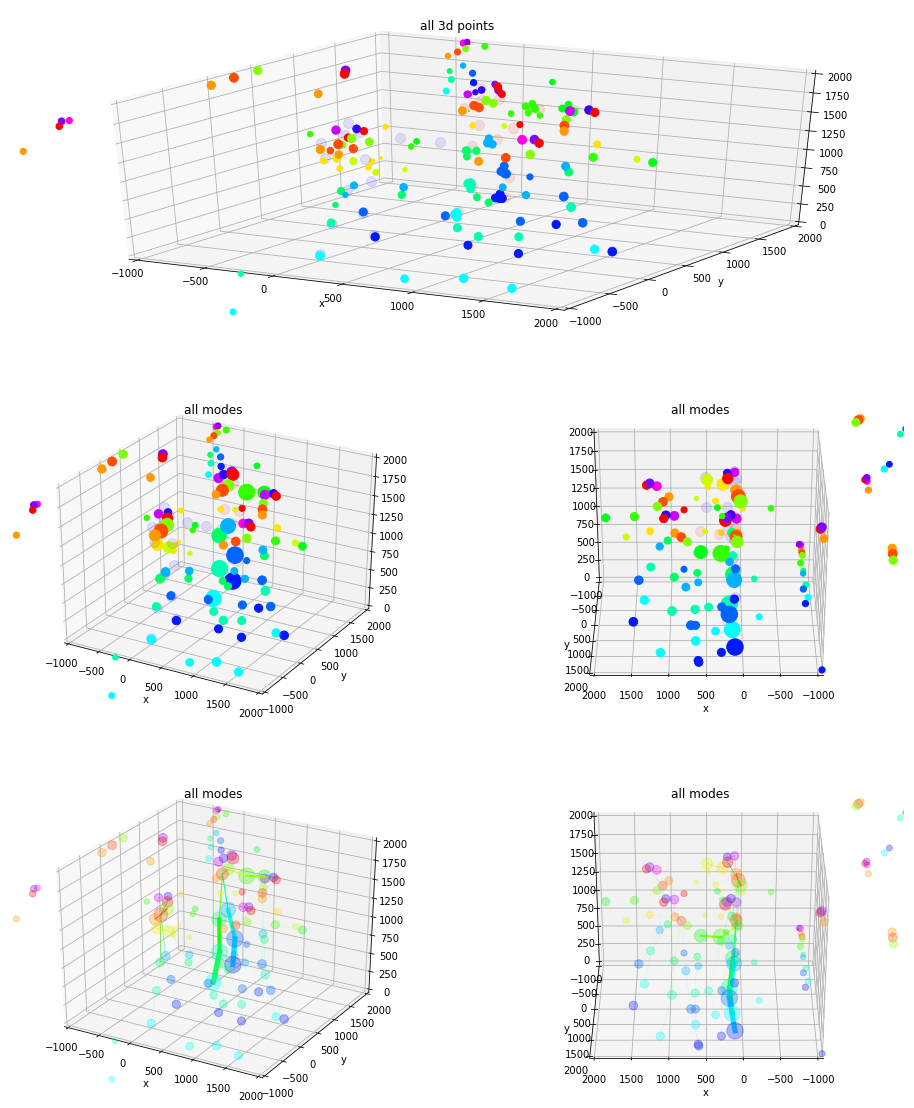

In [56]:
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH
from mvpose.algorithm.meanshift import find_all_modes
import numpy.linalg as la
from cselect import color as cs
from scipy.optimize import linear_sum_assignment

class Candidates:

    def __init__(self, peaks, limbs, Calib, r, sigma=None,
                 limbSeq=DEFAULT_LIMB_SEQ,
                 sensible_limb_length=DEFAULT_SENSIBLE_LIMB_LENGTH,
                 mode_between_distance=50,
                 threshold_drop_person=8):
        """
            triangulate all points in the cameras
        :param peaks: [{Peaks}]
        :param limbs: [{LimbWeights}]
        :param Calib: [{Camera}] The camera parameters MUST BE undistorted!
        :param r: {float} radius for meanshift
        :param sigma: {float} sigma for meanshift
        :param limbSeq: {np.array[m x 2]} ids represent the joint (relative to the heatmaps)
        :param sensible_limb_length: {np.array[m x 2]} (low, high) of sensible limb length'
        :param mode_between_distance: the maximal distance between two points of a cluster
                        This is being used for clustering the detected mode of all points
        :param threshold_drop_person: {integer} if less then this threshold
                        items are found: drop the whole detection
        :return: {Peaks3}, {LimbWeights3d}
        """
        n_cameras = len(Calib)
        n_joints = peaks[0].n_joints
        n_limbs = len(limbSeq)
        assert n_cameras == len(limbs)
        assert n_cameras == len(peaks)
        assert limbSeq.shape[1] == 2
        assert n_limbs == len(sensible_limb_length)
        
        POINTS_3d = [np.zeros((0, 4))] * n_joints  # per joint
        META = [np.zeros((0, 4), 'int32')] * n_joints  # per joint: [(cam1, cam2, idx1, idx2) ... ]
        # the meta data maps the points to their respective 2d camera pair
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 1: triangulate points
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        for cam1 in range(n_cameras - 1):
            K1, rvec1, tvec1, distCoef1 = \
                gm.get_camera_parameters(Calib[cam1])
            assert distCoef1 == 0
            peaks1 = peaks[cam1]
            
            for cam2 in range(cam1 + 1, n_cameras):
                K2, rvec2, tvec2, distCoef2 = \
                    gm.get_camera_parameters(Calib[cam2])
                assert distCoef2 == 0
                peaks2 = peaks[cam2]
                
                current_3d_peaks, idx_pairs = stereo.triangulate_argmax(
                    peaks1, K1, rvec1, tvec1, peaks2, K2, rvec2, tvec2)
                assert len(current_3d_peaks) == n_joints
                
                for k in range(n_joints):
                    n = idx_pairs[k].shape[0]
                    pts3d = current_3d_peaks[k]
                    assert len(pts3d) == n
                    
                    POINTS_3d[k] = np.concatenate(
                        [POINTS_3d[k], pts3d])
                    
                    for i in range(n):
                        idx1 = idx_pairs[k][i,0]
                        idx2 = idx_pairs[k][i,1]
                        meta = np.expand_dims([cam1, idx1, cam2, idx2], axis=0)
                        META[k] = np.append(META[k], meta, axis=0)
        
        self.points3d = POINTS_3d
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 2: calculate weights
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        limbs3d = []
        for lid, (k1, k2) in enumerate(limbSeq):
            d_low, d_high = sensible_limb_length[lid]
            meta1 = META[k1]
            meta2 = META[k2]
            pts1 = POINTS_3d[k1]
            pts2 = POINTS_3d[k2]
            
            n = len(meta1)
            m = len(meta2)
            assert n == len(pts1)
            assert m == len(pts2)
            
            W = np.zeros((n, m))
            
            for u, (cam_a1, a1, cam_b1, b1) in enumerate(meta1):
                for v, (cam_a2, a2, cam_b2, b2) in enumerate(meta2):
                    assert cam_a1 != cam_b1 and cam_a2 != cam_b2
                    if cam_a1 == cam_a2 and cam_b1 == cam_b2:
                        p1_3d = pts1[u][0:3]
                        p2_3d = pts2[v][0:3]
                        W1 = limbs[cam_a1][lid]
                        W2 = limbs[cam_b1][lid]
                        distance = la.norm(p1_3d - p2_3d)
                    
                        if d_low < distance < d_high:
                            W[u,v] = W1[a1,a2] + W2[b1,b2]
                        else:
                            W[u,v] = -9999999999
            
            limbs3d.append(W)
        self.limbs3d = limbs3d
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 3: find modes
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        r = float(r)
        if sigma is None:
            sigma = r
        
        modes3d = []
        
        for k in range(n_joints):
            sum
            modes = []
            
            Modes, Lookup = find_all_modes(POINTS_3d[k], r, sigma, 
                                           lim=0, between_distance=mode_between_distance)
            n = len(Modes)
            for i in range(n):
                w = np.sum(POINTS_3d[k][Lookup[i]][:,3])  # TODO: try out different techniques, e.g. mean
                item = [*Modes[i], w]
                modes.append(item)
            
            modes = np.array(modes)
            modes3d.append(
                (modes, Lookup)
            )
        
        self.modes3d = modes3d
        
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 4: calculate weight between modes
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        #W_limbs = [np.zeros((0, 0))] * n_limbs
        W_limbs = []
        for lid, (k1, k2) in enumerate(limbSeq):
            W_all_points = limbs3d[lid]  # Weight from all points
            
            d_low, d_high = sensible_limb_length[lid]
            
            # modes: [.. (x,y,z,score) ...]
            # lookup: [ [cluster1], [cluster2], ...]
            modes1, lookup1 = modes3d[k1]
            modes2, lookup2 = modes3d[k2]
            
            n = len(modes1)
            m = len(modes2)
            
            W = np.zeros((n, m)) 
            W_limbs.append(W)
        
            for u, (p1, idxs1) in enumerate(zip(modes1, lookup1)):
                for v, (p2, idxs2) in enumerate(zip(modes2, lookup2)):
                    
                    distance = la.norm(p1[0:3] - p2[0:3])
                    if d_low < distance < d_high:
                        for i in idxs1:
                            for j in idxs2:
                                W[u,v] += W_all_points[i,j] * p1[3] * p2[3]
                    else:
                        W[u,v] = -99999999999
        
        assert len(W_limbs) == n_limbs
        self.mode_limbs = W_limbs
            
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # step 5: extract human pose
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        pid = 0
        # represents all modes and their respetive pid (-1 => no person)
        modes_to_person = [[-1] * len(x[0]) for x in modes3d]
        
        for lid, (k1, k2) in enumerate(limbSeq):
            W = -W_limbs[lid]  # weight for the modes
            
            rows, cols = linear_sum_assignment(W)
            
            for a, b in zip(rows, cols):
                
                if W[a,b] > 0:
                    continue
                
                pid1 = modes_to_person[k1][a]
                pid2 = modes_to_person[k2][b]
                
                if pid1 == -1 and pid2 == -1:
                    modes_to_person[k1][a] = pid
                    modes_to_person[k2][b] = pid
                    pid += 1
                elif pid1 == -1:
                    modes_to_person[k1][a] = pid2
                elif pid2 == -1:
                    modes_to_person[k2][b] = pid1
                else:  # merge?
                    pass  # TODO: we need to do smthg here!
        
        # remove detections with too few points..
        count_pids = [0] * pid

        for pids in modes_to_person:
            for pid in pids:
                if pid >= 0:
                    count_pids[pid] += 1
        
        humans = {}
        for pid, count in enumerate(count_pids):
            if count > threshold_drop_person:
                #humans[pid] = [None] * len(modes_to_person)
                humans[pid] = {
                    'joints': [None] * len(modes_to_person),
                    'view_count': [0] * len(modes_to_person)
                }
                    
        for k, pids in enumerate(modes_to_person):
            for idx, pid in enumerate(pids):
                if pid in humans:
                    humans[pid]['joints'][k] = modes3d[k][0][idx]
                    humans[pid]['view_count'][k] = len(modes3d[k][1][idx])
        
        # AT LEAST one point per human must be visible in more than 1 view pair,
        # otherwise it is probably just noise!
        rm = []
        for pid, human in humans.items():
            cnt = human['view_count']
            if np.max(cnt) <= 1:
                rm.append(pid)
        
        for pid in rm:
            del humans[pid]
        
        self.humans = humans
        
        
# ======================================================
                

_start = time()
cand = Candidates(Peaks_undist, Limb_Weights, Calib_undist, r=200, mode_between_distance=50)
_end = time()
print('elapsed', _end - _start)

# --- plot all points ---

JOINT = 3

def set_cage(ax):
    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2000])
    ax.set_xlabel('x');  ax.set_ylabel('y')

points3d = cand.points3d

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(311, projection='3d'); set_cage(ax)
ax.set_title('all 3d points')

COLORS = cs.lincolor(len(points3d) + 3)/255
for k, P in enumerate(points3d):
    ax.scatter(P[:,0],P[:,1],P[:,2], color=COLORS[k], s=P[:,3]*100, alpha=1)


# ~~~~~~~ only modes ~~~~~~~
modes = cand.modes3d
ay1 = fig.add_subplot(323, projection='3d'); set_cage(ay1)
ay2 = fig.add_subplot(324, projection='3d'); set_cage(ay2); ay2.view_init(30, 90); 

def plt_mode(ay, alpha=1):
    ay.set_title('all modes')

    COLORS = cs.lincolor(len(modes) + 3)/255
    for k, P in enumerate(modes):
        if len(P[0]) > 0:
            ay.scatter(P[0][:,0],P[0][:,1],P[0][:,2], s=P[0][:,3]*100, color=COLORS[k], alpha=alpha)


plt_mode(ay1)
plt_mode(ay2)
            
# ---- plot ground truth ---
color = ['red', 'blue']
for x,y,z,pid in Y[FRAME]:
    ax.scatter([x],[y],[z], color=color[int(pid)], alpha=0.1, s=100)
    ay1.scatter([x],[y],[z], color=color[int(pid)], alpha=0.1, s=100)
    ay2.scatter([x],[y],[z], color=color[int(pid)], alpha=0.1, s=100)

    
# ---- plot weights ---
def plot_weights(ax, candidate):
    modes = candidate.modes3d
    COLORS = cs.lincolor(len(DEFAULT_LIMB_SEQ) + 3)/255
    for lid, (k1, k2) in enumerate(DEFAULT_LIMB_SEQ):
        
        W = candidate.mode_limbs[lid]
        n, m = W.shape
        
        pts1, _ = modes[k1]
        pts2, _ = modes[k2]
        assert len(pts1) == n
        assert len(pts2) == m
        
        for u, (x1,y1,z1,w1) in enumerate(pts1):
            for v, (x2,y2,z2,w2) in enumerate(pts2):
                w = max(0, W[u,v])
                ax.plot([x1,x2], [y1,y2], [z1,z2], 
                       color=COLORS[lid], linewidth=w/100, alpha=0.9)
        


ax = fig.add_subplot(325, projection='3d'); set_cage(ax)
plt_mode(ax, alpha=0.3)
plot_weights(ax, cand)

ax = fig.add_subplot(326, projection='3d'); set_cage(ax); ax.view_init(30, 90); 

plt_mode(ax, alpha=0.3)
plot_weights(ax, cand)

    
plt.show()

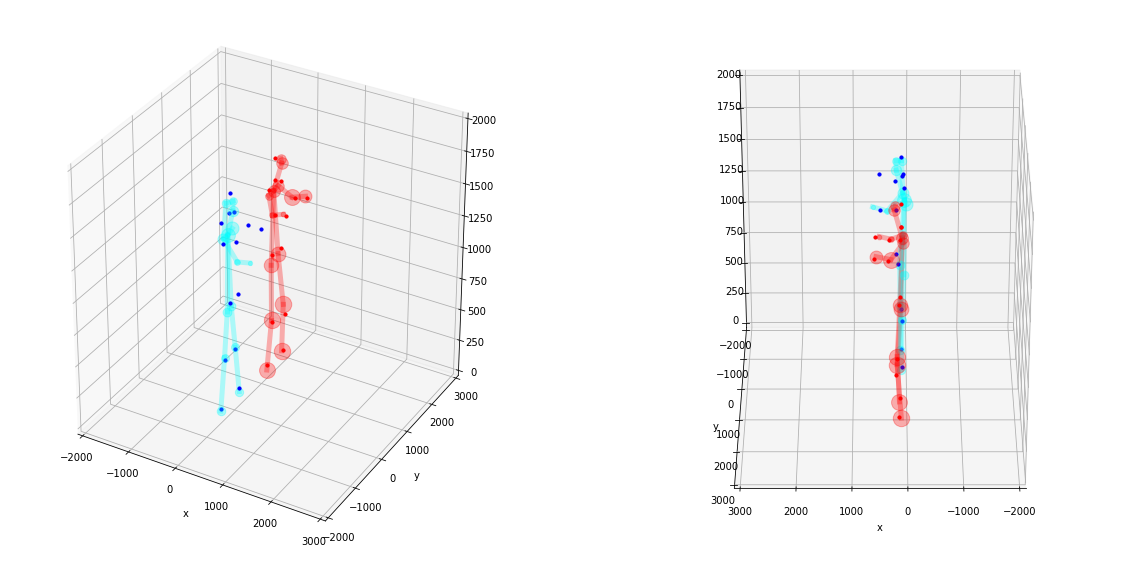

In [58]:
from mvpose.plot.skeleton import generate3d

def do_all(ax):
    ax.set_xlim([-2000, 3000])
    ax.set_ylim([-2000, 3000])
    ax.set_zlim([0, 2000])
    ax.set_xlabel('x');  ax.set_ylabel('y')

    humans = cand.humans

    COLORS = cs.lincolor(len(humans.keys()) + 1)/255

    for idx, (key, human) in enumerate(humans.items()):
        
        for p in human['joints']:
            if p is not None:
                x,y,z,w = p
                ax.scatter(x,y,z, color=COLORS[idx], s=w*100, alpha=0.3)

        generate3d(ax, human['joints'], DEFAULT_LIMB_SEQ, COLORS[idx], alpha=0.3)


    color = ['red', 'blue']
    for x,y,z,pid in Y[FRAME]:
        ax.scatter([x],[y],[z], color=color[int(pid)], alpha=1, s=10)
        

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
do_all(ax)

ax = fig.add_subplot(122, projection='3d'); ax.view_init(30, 90); 
do_all(ax)
    
plt.show()